### A Framework for Single-cell RNA Sequencing Analysis and A Variational Autoencoder with Flux Package 

#### Bayesian Inference for a Generative Model of Transcriptome Profiles from Single-cell RNA Sequencing
by $Romain Lopez^{1}$, $Jeffrey Regier^{1}$, $Michael Cole^{2}$, $Michael Jordan^{1,3}$ & $Nir Yosef^{1,5,6}$

#### Background

#### Biological Terminology

- Transcriptome: is a complete set of transcripts in a cell and their quantity, for a specific developement stage or physiological condition.

In other words, transcriptome is the set of RNA transcripts. The term can also sometimes be used to refer to all RNAs, or just mRNA.

- Single-Cell Transcriptomics: analysis of the transcriptom of a single cell.

- Gene Expression: is used in all known life and it is the process by which information from a gene is used in the synthesis of a functional gene product that enables it to produce protein as an end product. Gene Expression is most fundemental level at which the genotype gives rise to the phenotype. 




### Why is Single Cell Sequencing important? 



In development, sequencing the RNAs expressed by individual cells can give insight into the existence, function and behavior of different cell types. (e.g. cancer cells)

The figure below illustrates the Central DOGMA in molecular biology:

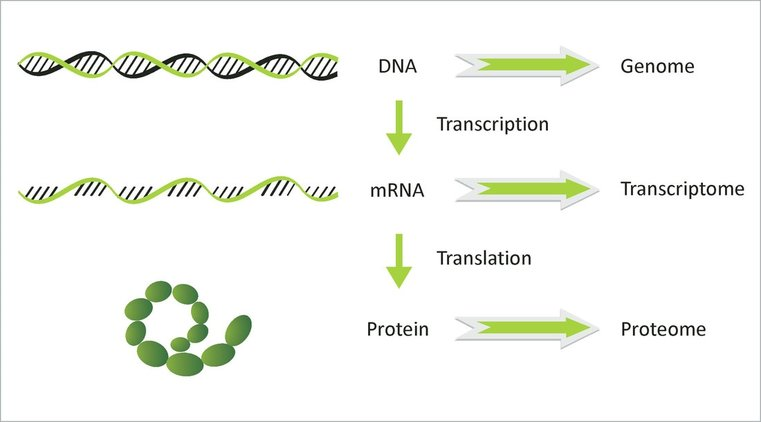

### Single-Cell Variational Inference Framework (scVI)

- Scalable framework for probabilistic representation. 
- Uses variational inference and stochastic optimization of neural network to approximate the parameters that govern the distribution of expression values of each gene in each cell.
- scVI is based on the hierarchical Bayesian model with conditional distribution specified by deep neural networks. 
- scVI used for fundemental analysis tasks: batch correction, visualization and clustering and differential experession.

### Model Definition

scRNA-seq Experiment Output: 
- NxG-matrix $x_{ng}$, Number of transcripts measured for each gene G in each of N cells. 
- $s_{n}$ batch annotation observed for each cell $n$.

#### Modeling:

- Expression level $x_{ng}$ modeled as sample drawn from ZINB which is conditioned on batch annotation, and on $l_{n}$ drawn from log-normal.
- $z_{n}$ represents the variability, which reflect the biological differences between the cells. $z_{n}$ is drawn from normal distribution and it is used for clustering and visualization.

### Dataset Example

CORTEX: consists of 3005 mouse cortex cells profiled with the Smart-Seq2 protocol.

Link to the dataset:

https://storage.googleapis.com/linnarsson-lab-www-blobs/blobs/cortex/expression_mRNA_17-Aug-2014.txt

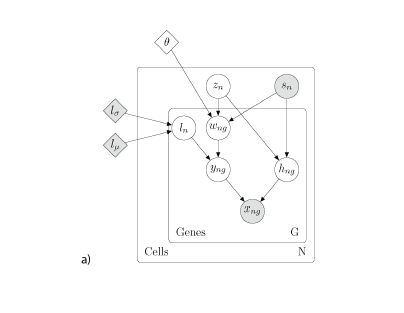

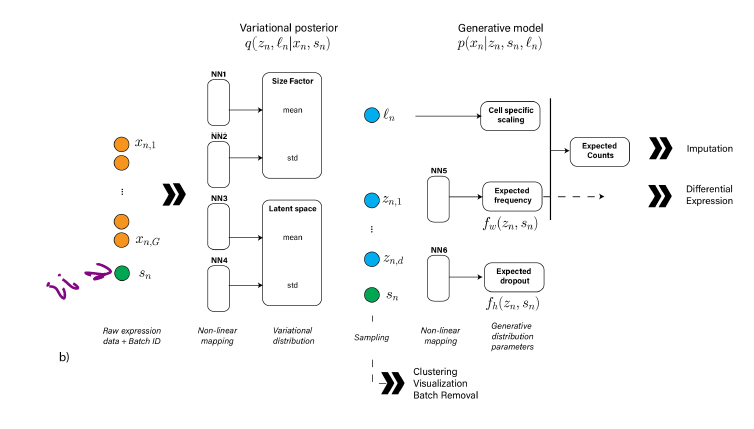

Each expression value $x_{ng}$ is drawn through the following process: 

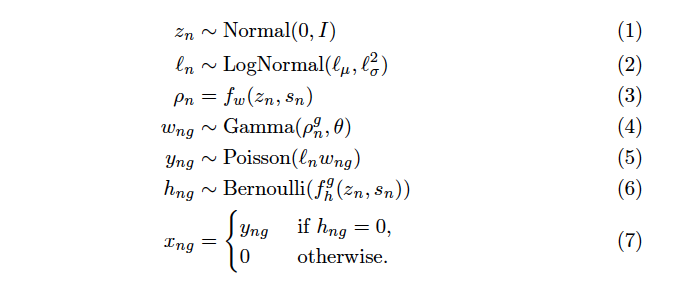

## Variational Autoencoder Implemetation using Flux Package

In the following cells, we will walk through implementing and training a VAE using Flux package.

Github for Flux Package:

https://github.com/FluxML

### Import the resources

In [8]:
# Source: 
# https://github.com/FluxML/model-zoo
# Variational Autoencoder(VAE)
#
# Auto-Encoding Variational Bayes
# Diederik P Kingma, Max Welling
# https://arxiv.org/abs/1312.6114

using BSON
using CUDA
using DrWatson: struct2dict
using Flux
using Flux: @functor, chunk
using Flux.Losses: logitbinarycrossentropy
using Flux.Data: DataLoader
using Images
using Logging: with_logger
using MLDatasets
using Parameters: @with_kw
using ProgressMeter: Progress, next!
using TensorBoardLogger: TBLogger, tb_overwrite
using Random

### Download the data

In [9]:
# load MNIST images and return loader
function get_data(batch_size)
    xtrain, ytrain = MLDatasets.MNIST.traindata(Float32)
    xtrain = reshape(xtrain, 28^2, :)
    DataLoader((xtrain, ytrain), batchsize=batch_size, shuffle=true)
end

get_data (generic function with 1 method)

In [10]:
get_data(128)

DataLoader{Tuple{Array{Float32,2},Array{Int64,1}}}((Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [5, 0, 4, 1, 9, 2, 1, 3, 1, 4  …  9, 2, 9, 5, 1, 8, 3, 5, 6, 8]), 128, 60000, true, 60000, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  59991, 59992, 59993, 59994, 59995, 59996, 59997, 59998, 59999, 60000], true)

### Create a struct for the Encoder of the VAE 

In [11]:
struct Encoder
    linear
    μ
    logσ
end

### Initialize the Encoder with 3 linear layars

In [12]:
@functor Encoder
    
Encoder(input_dim::Int, latent_dim::Int, hidden_dim::Int) = Encoder(
    Dense(input_dim, hidden_dim, tanh),   # linear
    Dense(hidden_dim, latent_dim),        # μ
    Dense(hidden_dim, latent_dim),        # logσ
)

Encoder

### Encoder Forwardpass 

In [13]:
function (encoder::Encoder)(x)
    h = encoder.linear(x)
    encoder.μ(h), encoder.logσ(h)
end

### Initialize the Decoder of the VAE with 2 linear layer  
The decoder reconstructs the original input 

In [14]:
Decoder(input_dim::Int, latent_dim::Int, hidden_dim::Int) = Chain(
    Dense(latent_dim, hidden_dim, tanh),
    Dense(hidden_dim, input_dim)
)

Decoder (generic function with 1 method)

In [15]:
function reconstuct(encoder, decoder, x, device)
    # encoder returns the mean and variance of the latents space
    μ, logσ = encoder(x)
    # sample from the latent space
    z = μ + device(randn(Float32, size(logσ))) .* exp.(logσ)
    # reconstruct the input by passing the z through the decoder
    μ, logσ, decoder(z)
end

reconstuct (generic function with 1 method)

In [16]:
function model_loss(encoder, decoder, λ, x, device)
    μ, logσ, decoder_z = reconstuct(encoder, decoder, x, device)
    len = size(x)[end]
    # KL-divergence
    # KL(q(z|x) || p(z|x)); calculate in closed form as both dist. are Gaussian
    kl_q_p = 0.5f0 * sum(@. (exp(2f0 * logσ) + μ^2 -1f0 - 2f0 * logσ)) / len
    
    # E[log P(x|z)]
    logp_x_z = -logitbinarycrossentropy(decoder_z, x, agg=sum) / len
    # regularization
    reg = λ * sum(x->sum(x.^2), Flux.params(decoder))
    
    -logp_x_z + kl_q_p + reg
end

model_loss (generic function with 1 method)

In [17]:
function convert_to_image(x, y_size)
    Gray.(permutedims(vcat(reshape.(chunk(x |> cpu, y_size), 28, :)...), (2, 1)))
end

convert_to_image (generic function with 1 method)

In [18]:
# arguments for the `train` function 
@with_kw mutable struct Args
    η = 1e-3                # learning rate
    λ = 0.01f0              # regularization paramater
    batch_size = 128        # batch size
    sample_size = 10        # sampling size for output    
    epochs = 20             # number of epochs
    seed = 0                # random seed
    cuda = true             # use GPU
    input_dim = 28^2        # image size
    latent_dim = 2          # latent dimension
    hidden_dim = 500        # hidden dimension
    verbose_freq = 10       # logging for every verbose_freq iterations
    tblogger = false        # log training with tensorboard
    save_path = "output"    # results path
end

Args

In [19]:
function train(; kws...)
    # load hyperparamters
    args = Args(; kws...)
    args.seed > 0 && Random.seed!(args.seed)

    # GPU config
    if args.cuda && CUDA.has_cuda()
        device = gpu
        @info "Training on GPU"
    else
        device = cpu
        @info "Training on CPU"
    end

    # load MNIST images
    loader = get_data(args.batch_size)
    
    # initialize encoder and decoder
    encoder = Encoder(args.input_dim, args.latent_dim, args.hidden_dim) |> device
    decoder = Decoder(args.input_dim, args.latent_dim, args.hidden_dim) |> device

    # ADAM optimizer
    opt = ADAM(args.η)
    
    # parameters
    ps = Flux.params(encoder.linear, encoder.μ, encoder.logσ, decoder)

    !ispath(args.save_path) && mkpath(args.save_path)

    # logging by TensorBoard.jl
    if args.tblogger
        tblogger = TBLogger(args.save_path, tb_overwrite)
    end

    # fixed input
    original, _ = first(get_data(args.sample_size^2))
    original = original |> device
    image = convert_to_image(original, args.sample_size)
    image_path = joinpath(args.save_path, "original.png")
    save(image_path, image)

    # training
    train_steps = 0
    @info "Start Training, total $(args.epochs) epochs"
    for epoch = 1:args.epochs
        @info "Epoch $(epoch)"
        progress = Progress(length(loader))

        for (x, _) in loader 
            loss, back = Flux.pullback(ps) do
                model_loss(encoder, decoder, args.λ, x |> device, device)
            end
            grad = back(1f0)
            Flux.Optimise.update!(opt, ps, grad)
            # progress meter
            next!(progress; showvalues=[(:loss, loss)]) 

            # logging with TensorBoard
            if args.tblogger && train_steps % args.verbose_freq == 0
                with_logger(tblogger) do
                    @info "train" loss=loss
                end
            end

            train_steps += 1
        end
        # save image
        _, _, rec_original = reconstuct(encoder, decoder, original, device)
        rec_original = sigmoid.(rec_original)
        image = convert_to_image(rec_original, args.sample_size)
        image_path = joinpath(args.save_path, "epoch_$(epoch).png")
        save(image_path, image)
        @info "Image saved: $(image_path)"
    end

    # save model
    model_path = joinpath(args.save_path, "model.bson") 
    let encoder = cpu(encoder), decoder = cpu(decoder), args=struct2dict(args)
        BSON.@save model_path encoder decoder args
        @info "Model saved: $(model_path)"
    end
end

train (generic function with 1 method)

In [20]:
train()

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /Users/sarajamal/.julia/packages/ProgressMeter/0ub8y/src/ProgressMeter.jl:474
Progress: 100%|█████████████████████████████████████████| Time: 0:00:29
  loss:  175.16507
┌ Info: Image saved: output/epoch_20.png
└ @ Main In[19]:73
┌ Info: Model saved: output/model.bson
└ @ Main In[19]:80


In [21]:
import Pkg; Pkg.add("Plots")

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [26]:
using Plots

function plot_result()
    BSON.@load "output/model.bson" encoder decoder args
    args = Args(; args...)
    device = args.cuda && CUDA.has_cuda() ? gpu : cpu
    encoder, decoder = encoder |> device, decoder |> device
    # load MNIST images
    loader = get_data(args.batch_size)

    # clustering in the latent space
    # visualize first two dims
    plt = scatter(palette=:rainbow)
    for (i, (x, y)) in enumerate(loader)
        i < 20 || break
        μ, logσ = encoder(x |> device)
        scatter!(μ[1, :], μ[2, :], 
            markerstrokewidth=0, markeralpha=0.8,
            aspect_ratio=1,
            markercolor=y, label="")
    end
    savefig(plt, "output/clustering.png")

    z = range(-2.0, stop=2.0, length=11)
    len = Base.length(z)
    z1 = repeat(z, len)
    z2 = sort(z1)
    x = zeros(Float32, args.latent_dim, len^2) |> device
    x[1, :] = z1
    x[2, :] = z2
    samples = decoder(x)
    samples = sigmoid.(samples)
    image = convert_to_image(samples, len)
    save("output/manifold.png", image)
end

if abspath(PROGRAM_FILE) == @__FILE__ 
    plot_result()
end

In [27]:
# Build GR run-time libraries otherwise you will receive an error.
ENV["GRDIR"]=""
Pkg.build("GR")

   Building GR → `~/.julia/packages/GR/9Vi4m/deps/build.log`


In [25]:
plot_result()

0

#### Clustering:

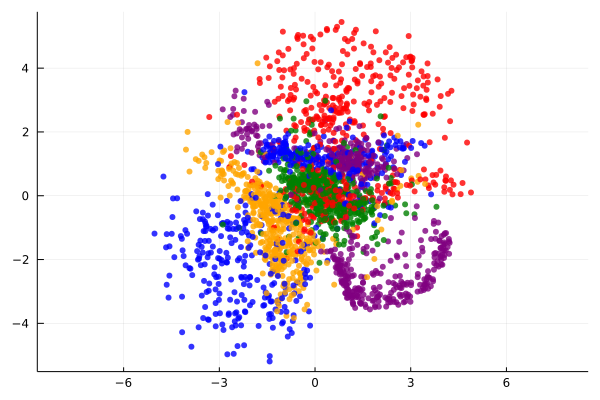

### References and Useful Links: 


Bayesian Inference for a Generative Model of Transcriptome Profiles from Single-cell RNA Sequencing

https://www.biorxiv.org/content/10.1101/292037v1

Flux Documentation

https://fluxml.ai/Flux.jl/stable/

BSON for saving and loading the models

https://fluxml.ai/Flux.jl/v0.9/saving/ 

BSON

https://github.com/JuliaIO/BSON.jl

Plots

https://docs.juliaplots.org/latest/tutorial/